In [3]:
%pip install cpi

import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import cpi

# Update CPI data (important to get latest data)
cpi.update()

def adjust_for_inflation(amount, from_year, to_year):
    return cpi.inflate(amount, int(from_year), int(to_year))

Note: you may need to restart the kernel to use updated packages.


c:\Users\theco\AppData\Local\Programs\Python\Python311\Lib\site-packages\cpi\download.py:175: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(response.text), sep="\t")
c:\Users\theco\AppData\Local\Programs\Python\Python311\Lib\site-packages\cpi\download.py:175: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(response.text), sep="\t")


Load in data and clean player names


In [4]:
#makes the dataframes
salary_df = pd.read_csv('data/salary2024.csv')

pg_df = pd.read_csv('data/Player Per Game.csv')
advanced_df = pd.read_csv('data/Advanced.csv')

#now clean these dataframes and normalize the players names by removing accent marks
pg_df['player'] = pg_df['player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
advanced_df['player'] = advanced_df['player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# print(salary_df.head(), "\n\n")
# print(pg_df.head(), "\n\n")
# print(advanced_df.head(), "\n\n")

Finish cleaning and make combined data frame that models will use


In [5]:
#CLEAN DF AND MERGE

#combines all the data frames into one data frame, merged on player_names in salary_df and player in the others and year
merged_df = pd.merge(pg_df, advanced_df, on=['player', 'season'], suffixes=('', '_dup'))
# Drop the duplicate columns
merged_df = merged_df.loc[:, ~merged_df.columns.str.endswith('_dup')]

#do other merge
merged_df = pd.merge(salary_df, merged_df, left_on=['player_names', 'season'], right_on=['player', 'season'])


#select Nikola Jokic from merged dataframe

merged_df = merged_df.drop(columns=['player','birth_year', 'lg', 'Unnamed: 0', 'seas_id','player_id'])
print(merged_df.columns)



#change season to int
merged_df['season'] = merged_df['season'].astype(int)

#find number of NANs in the columns
# print(merged_df.isna().sum())

#Fill NAN with nan, as they have no attempts
merged_df = merged_df.fillna(0)

#find number of NANs in the columns
# print(merged_df.isna().sum())

# merged_df[['ft_percent','ft_per_game']]
merged_df[merged_df['player_names'] == 'Nikola Jokic']
# merged_df.sort_values(by='vorp', ascending=False)
# print(np_array)

Index(['player_names', 'season', 'salaries', 'pos', 'age', 'experience', 'tm',
       'g', 'gs', 'mp_per_game', 'fg_per_game', 'fga_per_game', 'fg_percent',
       'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game',
       'x2pa_per_game', 'x2p_percent', 'e_fg_percent', 'ft_per_game',
       'fta_per_game', 'ft_percent', 'orb_per_game', 'drb_per_game',
       'trb_per_game', 'ast_per_game', 'stl_per_game', 'blk_per_game',
       'tov_per_game', 'pf_per_game', 'pts_per_game', 'mp', 'per',
       'ts_percent', 'x3p_ar', 'f_tr', 'orb_percent', 'drb_percent',
       'trb_percent', 'ast_percent', 'stl_percent', 'blk_percent',
       'tov_percent', 'usg_percent', 'ows', 'dws', 'ws', 'ws_48', 'obpm',
       'dbpm', 'bpm', 'vorp'],
      dtype='object')


,player_names,season,salaries,pos,age,experience,tm,g,gs,mp_per_game,...,tov_percent,usg_percent,ows,dws,ws,ws_48,obpm,dbpm,bpm,vorp
20097,Nikola Jokic,2016,"$1,300,000",C,20.0,1,DEN,80,55.0,21.7,...,13.2,19.9,4.5,2.2,6.7,0.185,2.6,1.3,3.9,2.6
20984,Nikola Jokic,2017,"$1,358,500",C,21.0,2,DEN,73,59.0,27.9,...,15.2,23.5,7.7,2.0,9.7,0.228,5.9,1.4,7.3,4.8
21923,Nikola Jokic,2018,"$1,471,382",C,22.0,3,DEN,75,73.0,32.6,...,15.5,24.2,7.8,2.9,10.7,0.211,5.3,1.6,6.9,5.5
22225,Nikola Jokic,2019,"$25,467,250",C,23.0,4,DEN,80,80.0,31.3,...,15.4,27.4,7.5,4.3,11.8,0.226,6.2,2.9,9.1,7.0
23355,Nikola Jokic,2020,"$27,504,630",C,24.0,5,DEN,73,73.0,32.0,...,15.8,26.6,6.7,3.1,9.8,0.202,5.5,2.0,7.4,5.5
24274,Nikola Jokic,2021,"$29,542,010",C,25.0,6,DEN,72,72.0,34.6,...,13.1,29.6,12.2,3.4,15.6,0.301,9.1,3.0,12.1,8.8
25329,Nikola Jokic,2022,"$31,044,906",C,26.0,7,DEN,74,74.0,33.5,...,15.6,31.9,10.8,4.5,15.2,0.296,9.2,4.5,13.7,9.8
26632,Nikola Jokic,2023,"$33,047,803",C,27.0,8,DEN,69,69.0,33.7,...,17.0,27.2,11.2,3.8,14.9,0.308,8.5,4.5,13.0,8.8
27585,Nikola Jokic,2024,"$47,607,350",C,28.0,9,DEN,79,79.0,34.6,...,12.9,29.3,12.0,5.1,17.0,0.299,9.0,4.2,13.2,10.6


Clean Salaries and adjust for inflation


In [6]:
#adjust for inflation
merged_df['salaries'] = merged_df['salaries'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)


In [7]:
unique_years = merged_df['season'].unique()
if(2024 in unique_years): #REMOVE 2024 FROM LIST
    unique_years = np.delete(unique_years, np.where(unique_years == 2024))
cpi_ratios = {year: cpi.inflate(1, year, 2023) for year in unique_years}
cpi_ratios[2024] = 1.0

# Use the precomputed ratios to adjust salaries
merged_df['adj_salaries'] = merged_df['season'].map(cpi_ratios) * merged_df['salaries']




**Now it is time to actually fit a model, I will fit 2 regression models, one to fit VORP and the other to Fit Salary**

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import OneHotEncoder

# Separate features (X) and target (y)
X = merged_df.drop(columns=['vorp', 'salaries', 'player_names', 'ws' , 'ows', 'dws', 'mp', 'ws_48']) #remove columns that use winshare, as vorp is regularized winshares`
y = merged_df['vorp']

# Perform one-hot encoding on categorical features (e.g., team)
categorical_features = ['tm','pos']  # Add other categorical features as needed
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(X[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
X = X.drop(columns=categorical_features).join(encoded_df)


# Feature selection using SelectKBest with f_regression
k = 20
selector = SelectKBest(score_func=f_regression, k=k) # Choose the best 10 features
X_selected = selector.fit_transform(X, y)

# Get the selected feature names
selected_feature_names = X.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, y, test_size=0.2, random_state=2)


from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=k, random_state=0)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


#now add predictions to the df
# merged_df['salary_pred'] = y_pred

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


# Calculate Adjusted R-squared
n = X_test.shape[0]  # number of observations
p = X_test.shape[1]  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R-squared:", adjusted_r2)



# Get feature importances and other summary statistics on the params like in linear regression
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_,

})

print(feature_importance_rf.sort_values(by='Importance', ascending=False))


# Sort by importance
# print(feature_importance_rf)


# # To get p-values and detailed summary, use statsmodels OLS on the selected features
# X_train_sm = sm.add_constant(X_train)  # add constant for intercept
# ols_model = sm.OLS(y_train, X_train_sm).fit()

# # Summary of the statsmodels OLS model, showing p-values and confidence intervals
# print(ols_model.summary())

# merged_df['vorp_pred'] = model.predict(X_selected_df)
# #find accuracy of preds
# accuracy = np.mean(np.abs((merged_df['vorp'] - merged_df['vorp_pred']) / merged_df['vorp']))
# print("Accuracy:", accuracy)


Mean Squared Error: 0.13584442603894217
R-squared: 0.88055499721523
Adjusted R-squared: 0.8801369188015626
          Feature  Importance
17            per    0.351852
2     mp_per_game    0.303349
16   pts_per_game    0.113624
1              gs    0.058356
0               g    0.039109
14   stl_per_game    0.021971
8   x2pa_per_game    0.020288
13   ast_per_game    0.012966
18    ast_percent    0.012554
7    x2p_per_game    0.009053
19   adj_salaries    0.008534
15   tov_per_game    0.006715
12   trb_per_game    0.005946
5    x3p_per_game    0.005735
6   x3pa_per_game    0.005612
10   fta_per_game    0.005395
4    fga_per_game    0.005281
11   drb_per_game    0.004964
9     ft_per_game    0.004944
3     fg_per_game    0.003750


In [9]:
#NOW WITH SALARIES

# Separate features (X) and target (y)
X = merged_df.drop(columns=['vorp', 'salaries', 'adj_salaries', 'player_names'])
# X = X.drop(columns=['adj_salaries_pred'])
y = merged_df['adj_salaries']



# Perform one-hot encoding on categorical features (e.g., team)
categorical_features = ['tm','pos']  # Add other categorical features as needed
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(X[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
X = X.drop(columns=categorical_features).join(encoded_df)




# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, y, test_size=0.2, random_state=0)

# # Create and train the linear regression model
# model = LinearRegression()
# model.fit(X_train, y_train)
# Make predictions on the test set
# y_pred = model.predict(X_test)
k = 20

selector = SelectKBest(score_func=f_regression, k=k) # Choose the best 10 features
X_selected = selector.fit_transform(X, y)

# Get the selected feature names
selected_feature_names = X.columns[selector.get_support()]
X_selected_df2 = pd.DataFrame(X_selected, columns=selected_feature_names)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_df2, y, test_size=0.2, random_state=2)


from sklearn.ensemble import RandomForestRegressor
rf_model2 = RandomForestRegressor(n_estimators=k, random_state=0)
rf_model2.fit(X_train, y_train)

y_pred = rf_model2.predict(X_test)


#now add predictions to the df
# merged_df['salary_pred'] = y_pred

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


# Calculate Adjusted R-squared
n = X_test.shape[0]  # number of observations
p = X_test.shape[1]  # number of predictors
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R-squared:", adjusted_r2)



# Get feature importances and other summary statistics on the params like in linear regression
feature_importance_rf2 = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model2.feature_importances_,

})

print(feature_importance_rf.sort_values(by='Importance', ascending=False))


# # To get p-values and detailed summary, use statsmodels OLS on the selected features
# X_train_sm = sm.add_constant(X_train)  # add constant for intercept
# ols_model = sm.OLS(y_train, X_train_sm).fit()

# # Summary of the statsmodels OLS model, showing p-values and confidence intervals
# print(ols_model.summary())




Mean Squared Error: 11319339985849.578
R-squared: 0.769013942691678
Adjusted R-squared: 0.7682054510665176
          Feature  Importance
17            per    0.351852
2     mp_per_game    0.303349
16   pts_per_game    0.113624
1              gs    0.058356
0               g    0.039109
14   stl_per_game    0.021971
8   x2pa_per_game    0.020288
13   ast_per_game    0.012966
18    ast_percent    0.012554
7    x2p_per_game    0.009053
19   adj_salaries    0.008534
15   tov_per_game    0.006715
12   trb_per_game    0.005946
5    x3p_per_game    0.005735
6   x3pa_per_game    0.005612
10   fta_per_game    0.005395
4    fga_per_game    0.005281
11   drb_per_game    0.004964
9     ft_per_game    0.004944
3     fg_per_game    0.003750


Now add predictions & residuals to df to calcluate metrics



In [10]:
merged_df['adj_salaries_pred'] = rf_model2.predict(X_selected_df2)
merged_df['vorp_pred'] = rf_model.predict(X_selected_df)

In [11]:
#now find more metrics using the DF values

#add residuals to the df for both models
merged_df['residuals_vorp'] = merged_df['vorp'] - merged_df['vorp_pred']
merged_df['residuals_salary'] = (merged_df['adj_salaries']) - merged_df['adj_salaries_pred']


#find sMAPE and print it
def smape(actual, predicted):
    return np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

smap_vorp = smape(merged_df['vorp'], merged_df['vorp_pred'])
smap_salary = smape(merged_df['adj_salaries'], merged_df['adj_salaries_pred'])
print(f"sMAPE for VORP: {smap_vorp}")
print(f"sMAPE for Salary: {smap_salary}")

#find oob metric and print it
oob_vorp = 1 - (np.sum(merged_df['residuals_vorp']**2) / np.sum((merged_df['vorp'] - np.mean(merged_df['vorp']))**2))
oob_salary = 1 - (np.sum(merged_df['residuals_salary']**2) / np.sum((merged_df['adj_salaries'] - np.mean(merged_df['adj_salaries']))**2))
print(f"OOB for VORP: {oob_vorp}")
print(f"OOB for Salary: {oob_salary}")


sMAPE for VORP: 0.6004489083741477
sMAPE for Salary: 0.2639211319983561
OOB for VORP: 0.9632554200990407
OOB for Salary: 0.925625067981359


Compare the variables of intrestet to see what is diffrent between the 2


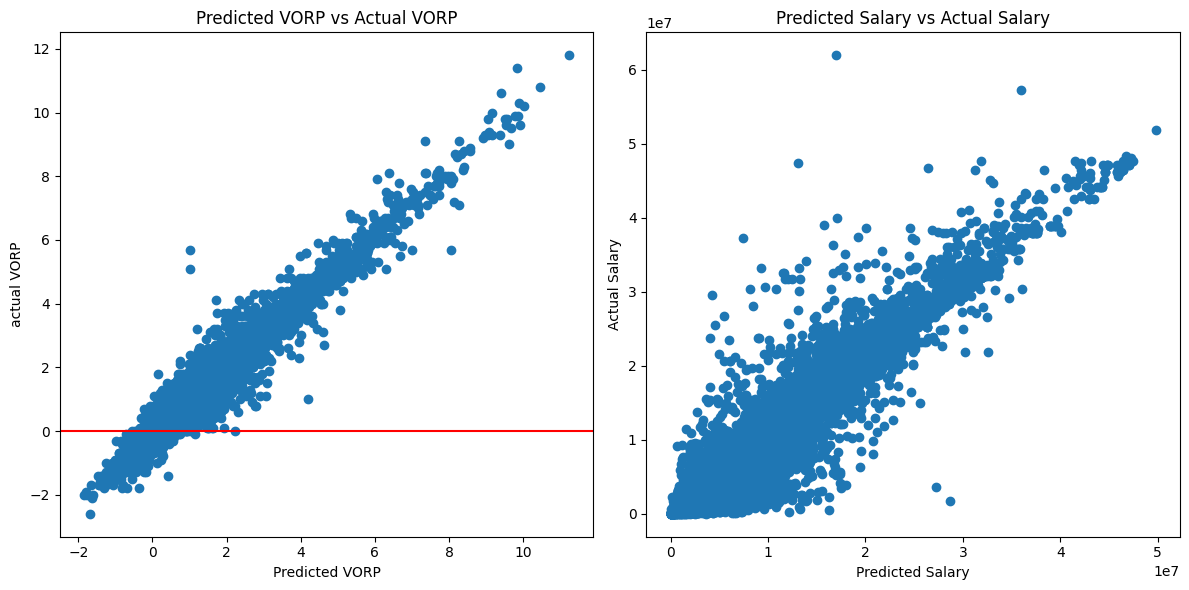

In [12]:
#create plots of actual vs predicted for both models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(merged_df['vorp_pred'], merged_df['vorp'])
plt.xlabel('Predicted VORP')
plt.ylabel('actual VORP')
plt.title('Predicted VORP vs Actual VORP')
plt.axhline(y=0, color='r', linestyle='-')

plt.subplot(1, 2, 2)
plt.scatter(merged_df['adj_salaries_pred'], merged_df['adj_salaries'])
plt.xlabel('Predicted Salary')
plt.ylabel('Actual Salary')
plt.title('Predicted Salary vs Actual Salary')
# plt.axhline(y=0, color='r', linestyle='-')

plt.tight_layout()
plt.show()

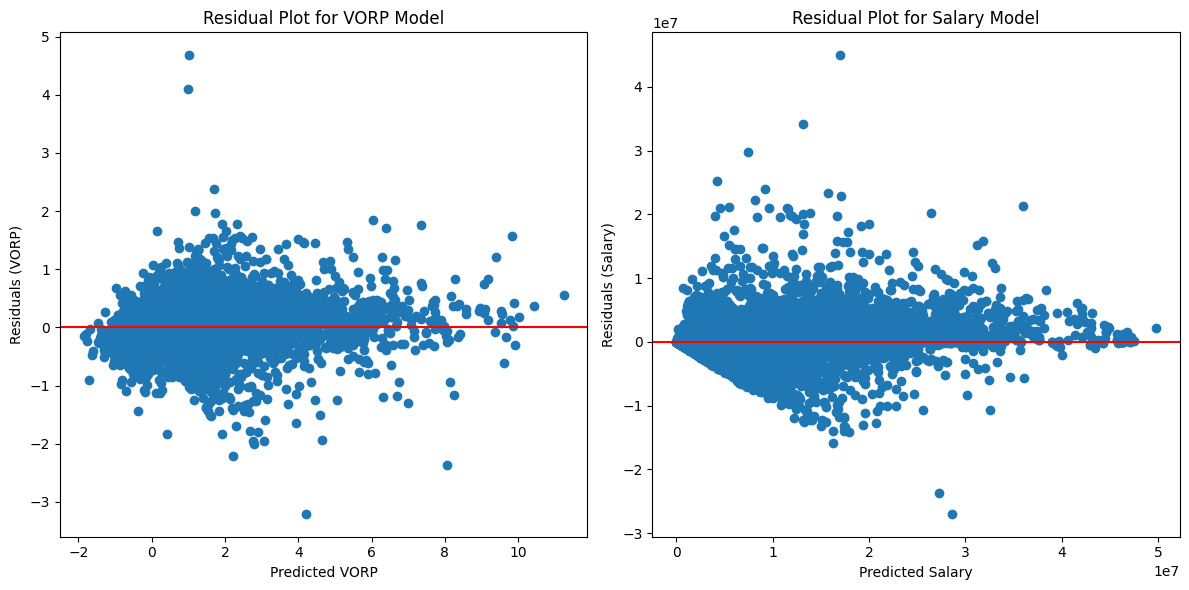

In [13]:
# Create plots for the residuals for both models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(merged_df['vorp_pred'], merged_df['residuals_vorp'])
plt.xlabel('Predicted VORP')
plt.ylabel('Residuals (VORP)')
plt.title('Residual Plot for VORP Model')
plt.axhline(y=0, color='r', linestyle='-')

plt.subplot(1, 2, 2)
plt.scatter(merged_df['adj_salaries_pred'], merged_df['residuals_salary'])
plt.xlabel('Predicted Salary')
plt.ylabel('Residuals (Salary)')
plt.title('Residual Plot for Salary Model')
plt.axhline(y=0, color='r', linestyle='-')

plt.tight_layout()
plt.show()

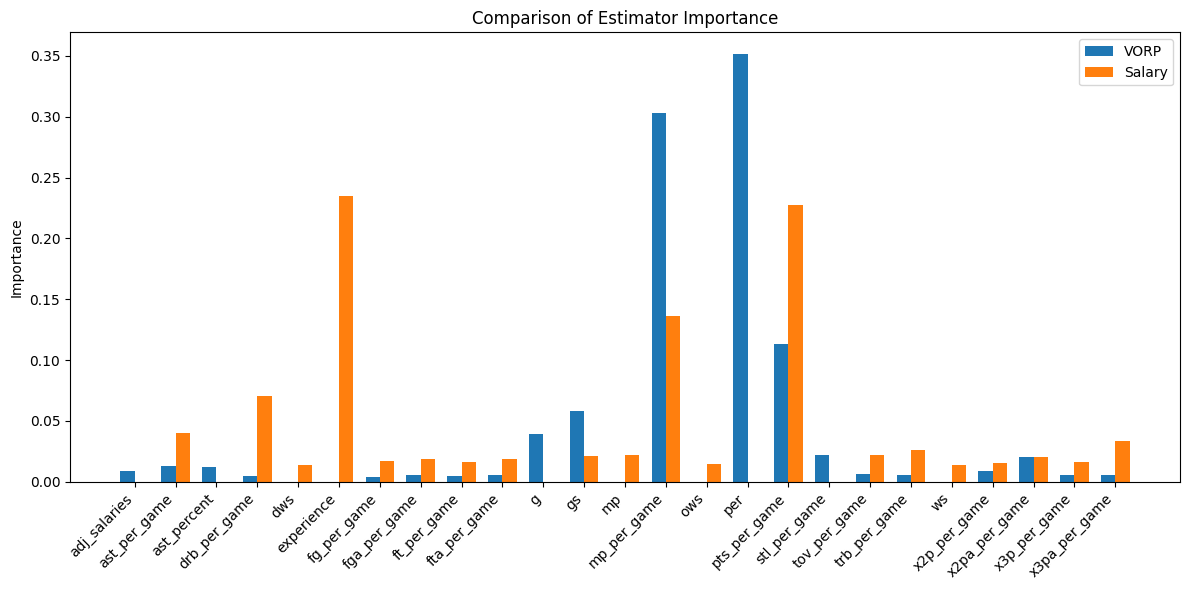

In [14]:
def compare_estimator_importance(feature_importance_rf1, feature_importance_rf2):
  """
  Compares the importance of estimators between two models and creates a bar chart.

  Args:
    feature_importance_rf1: DataFrame containing feature importance for model 1.
    feature_importance_rf2: DataFrame containing feature importance for model 2.
  """

  if feature_importance_rf1 is None:
    feature_importance_rf1 = pd.DataFrame({'Feature': [], 'Importance': []})

  if feature_importance_rf2 is None:
    feature_importance_rf2 = pd.DataFrame({'Feature': [], 'Importance': []})

  # Merge the feature importance dataframes
  merged_importance = pd.merge(feature_importance_rf1, feature_importance_rf2, on='Feature', how='outer', suffixes=('_model1', '_model2'))
  merged_importance = merged_importance.fillna(0)

  # Create a bar chart comparing the feature importance between the two models
  x = np.arange(len(merged_importance['Feature']))
  width = 0.35

  fig, ax = plt.subplots(figsize=(12, 6))
  rects1 = ax.bar(x - width / 2, merged_importance['Importance_model1'], width, label='VORP')
  rects2 = ax.bar(x + width / 2, merged_importance['Importance_model2'], width, label='Salary')

  ax.set_ylabel('Importance')
  ax.set_title('Comparison of Estimator Importance')
  ax.set_xticks(x)
  ax.set_xticklabels(merged_importance['Feature'], rotation=45, ha='right')
  ax.legend()

  plt.tight_layout()
  plt.show()


# Assuming you have feature_importance_rf and feature_importance_rf2 defined
# from the previous code blocks
compare_estimator_importance(feature_importance_rf, feature_importance_rf2)

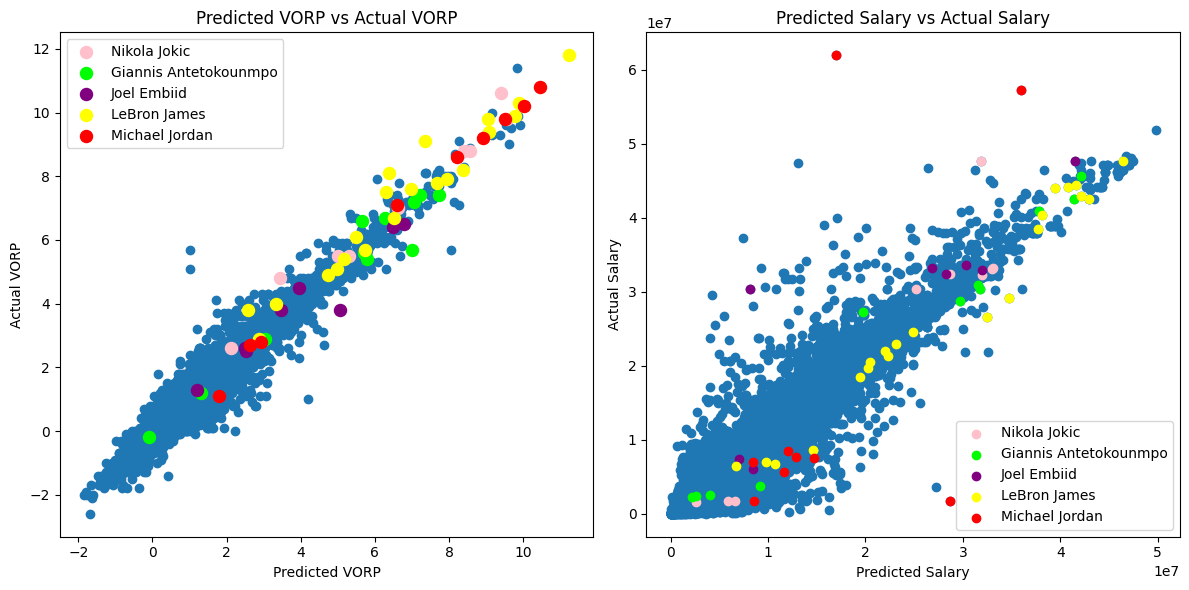

In [15]:
# Assuming merged_df contains 'vorp', 'vorp_pred', 'adj_salaries', 'adj_salaries_pred'
# and 'player_names'

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(merged_df['vorp_pred'], merged_df['vorp'])
plt.xlabel('Predicted VORP')
plt.ylabel('Actual VORP')
plt.title('Predicted VORP vs Actual VORP')

# Highlight specific player names with different colors
highlighted_players = ['Nikola Jokic', 'Giannis Antetokounmpo', 'Joel Embiid', 'LeBron James', 'Michael Jordan']  # Add more players here
colors = ['pink', 'lime', 'purple', 'yellow', 'red']  # Add more colors if needed
for i, player in enumerate(highlighted_players):
    player_data = merged_df[merged_df['player_names'] == player]
    if not player_data.empty:
        plt.scatter(player_data['vorp_pred'], player_data['vorp'], color=colors[i], label=player, s= 75)

plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(merged_df['adj_salaries_pred'], merged_df['adj_salaries'])
plt.xlabel('Predicted Salary')
plt.ylabel('Actual Salary')
plt.title('Predicted Salary vs Actual Salary')

# Highlight specific player names with different colors
for i, player in enumerate(highlighted_players):
    player_data = merged_df[merged_df['player_names'] == player]
    if not player_data.empty:
        plt.scatter(player_data['adj_salaries_pred'], player_data['adj_salaries'], color=colors[i], label=player)

plt.legend()

plt.tight_layout()
plt.show()

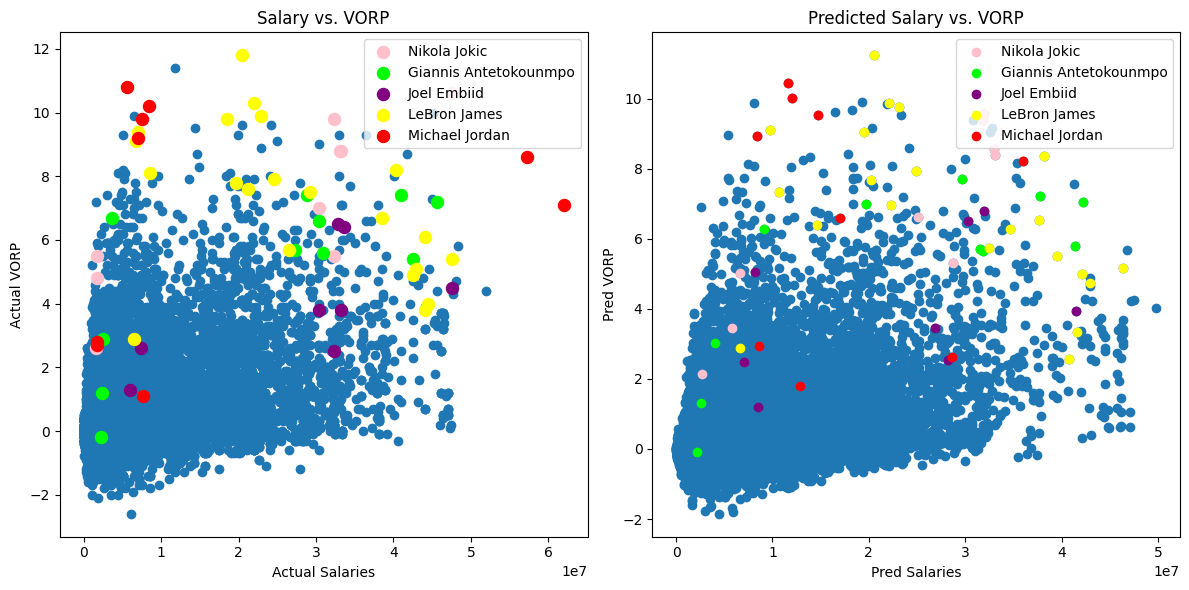

In [16]:
# Assuming merged_df contains 'vorp', 'vorp_pred', 'adj_salaries', 'adj_salaries_pred'
# and 'player_names'

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(merged_df['adj_salaries'], merged_df['vorp'])
plt.xlabel('Actual Salaries')
plt.ylabel('Actual VORP')
plt.title('Salary vs. VORP')

# Highlight specific player names with different colors
highlighted_players = ['Nikola Jokic', 'Giannis Antetokounmpo', 'Joel Embiid', 'LeBron James', 'Michael Jordan']  # Add more players here
colors = ['pink', 'lime', 'purple', 'yellow', 'red']  # Add more colors if needed
for i, player in enumerate(highlighted_players):
    player_data = merged_df[merged_df['player_names'] == player]
    if not player_data.empty:
        plt.scatter(player_data['adj_salaries'], player_data['vorp'], color=colors[i], label=player, s= 75)

plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(merged_df['adj_salaries_pred'], merged_df['vorp_pred'])
plt.xlabel('Pred Salaries')
plt.ylabel('Pred VORP')
plt.title('Predicted Salary vs. VORP')

# Highlight specific player names with different colors
for i, player in enumerate(highlighted_players):
    player_data = merged_df[merged_df['player_names'] == player]
    if not player_data.empty:
        plt.scatter(player_data['adj_salaries_pred'], player_data['vorp_pred'], color=colors[i], label=player)

plt.legend()

plt.tight_layout()
plt.show()

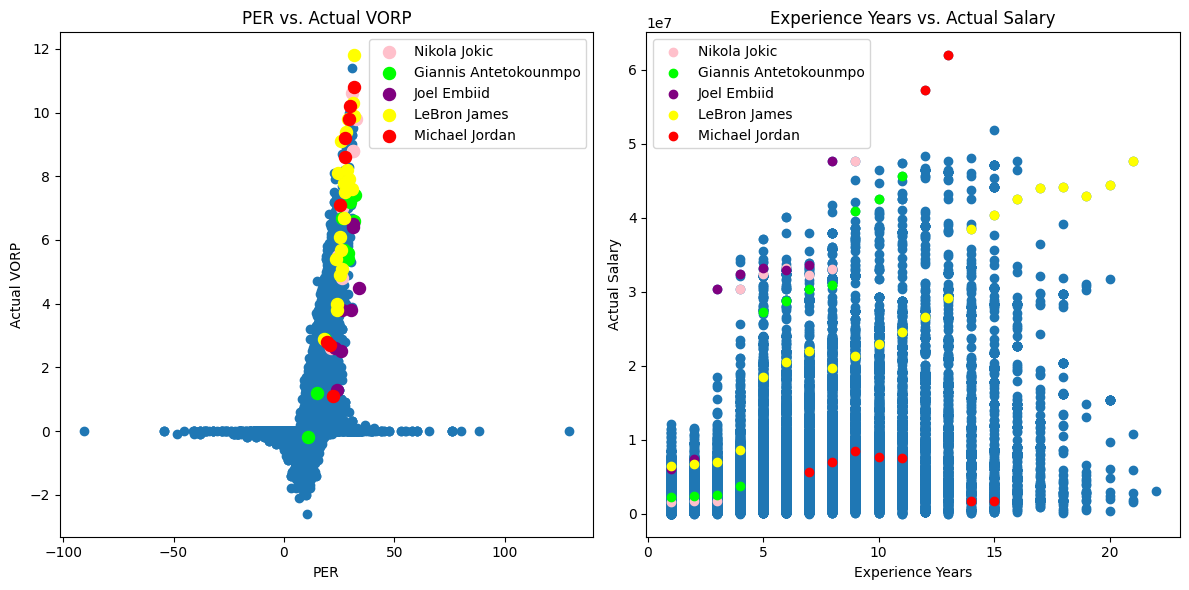

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(merged_df['per'], merged_df['vorp'])
plt.xlabel('PER')
plt.ylabel('Actual VORP')
plt.title('PER vs. Actual VORP')

# Highlight specific player names with different colors
highlighted_players = ['Nikola Jokic', 'Giannis Antetokounmpo', 'Joel Embiid', 'LeBron James', 'Michael Jordan']  # Add more players here
colors = ['pink', 'lime', 'purple', 'yellow', 'red']  # Add more colors if needed
for i, player in enumerate(highlighted_players):
    player_data = merged_df[merged_df['player_names'] == player]
    if not player_data.empty:
        plt.scatter(player_data['per'], player_data['vorp'], color=colors[i], label=player, s= 75)

plt.legend()


plt.subplot(1, 2, 2)
plt.scatter(merged_df['experience'], merged_df['adj_salaries'])
plt.xlabel('Experience Years')
plt.ylabel('Actual Salary')
plt.title('Experience Years vs. Actual Salary')

# Highlight specific player names with different colors
for i, player in enumerate(highlighted_players):
    player_data = merged_df[merged_df['player_names'] == player]
    if not player_data.empty:
        plt.scatter(player_data['experience'], player_data['adj_salaries'], color=colors[i], label=player)

plt.legend()

plt.tight_layout()
plt.show()